# Research Methodology (Summary)

<img src="Feature extraction Roadmap.png">

# Data Importation

In [261]:
import numpy as np
from scipy.io import loadmat
import pandas as pd
import antropy as ant

In [4]:
# import the data for patient 1
dict_ = loadmat('2_EEG200908190811.mat')
dict_.keys()

dict_keys(['__header__', '__version__', '__globals__', 'BIS', 'x', 'CH2', 'Denoised_x', 'CH2Denoised_x'])

<br/>

# Exploration

We'll be using the **CH2Denoised_x** and **BIS** columns

In [5]:
import matplotlib.pyplot as plt

data = dict_.get('CH2Denoised_x')
data = np.ravel(data)

In [6]:
bis = dict_.get('BIS')
bis = np.ravel(bis)

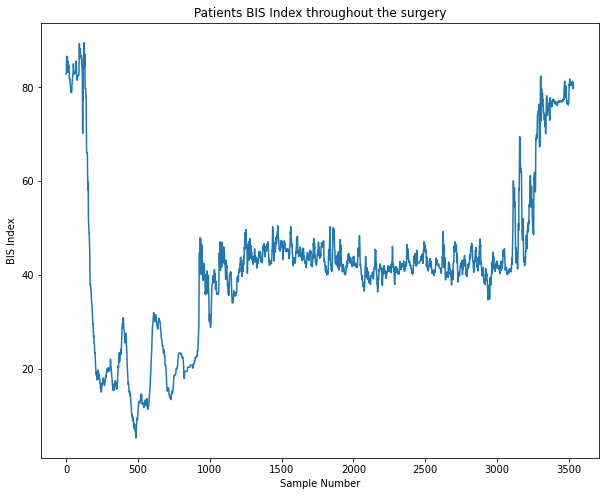

In [7]:
# Patient's BIS values throughout the surgery
fig = plt.figure(figsize=(10, 8))
plt.plot(bis)
plt.xlabel("Sample Number")
plt.ylabel("BIS Index")
plt.title("Patients BIS Index throughout the surgery")
plt.show()

<br/>

The EEG signal was sampled at a frequency of $128Hz$. So, each BIS value was calculated using $128$ samples of the EEG signal.

<br/>

# Walkthrough

Before the **Windowing** and **Feature Extraction** are discussed, a walkthrough on EEG preprocessing is provided. EEG data on the ***awake*** state of Patient 1 is used in this section.

## Patient's BIS values in the awake state

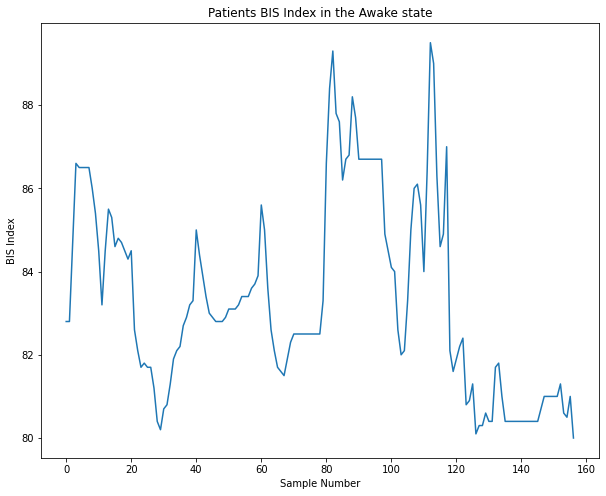

In [258]:
# sampling rate
fs = 128

# bis values in the awake state
awake_idx = np.where((bis <=100) & (bis >= 80))
awake = bis[awake_idx]

# The corresponding EEG in the awake state
eeg_sample = data[:awake.shape[0]*fs]



# Patient's BIS values in the awake state
fig = plt.figure(figsize=(10, 8))
plt.plot(awake)
plt.xlabel("Sample Number")
plt.ylabel("BIS Index")
plt.title("Patients BIS Index in the Awake state")
plt.show()

## Patients EEG sample in the Awake state

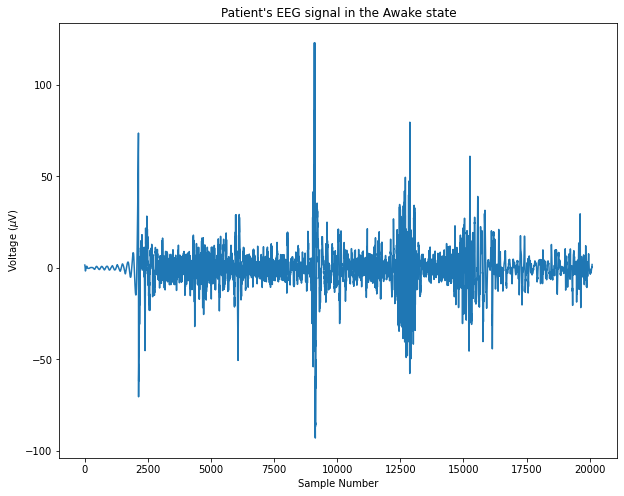

In [257]:
# Patient's EEG data in the awake state
fig = plt.figure(figsize=(10, 8))
plt.plot(eeg_sample)
plt.xlabel("Sample Number")
plt.ylabel("Voltage ($\mu$V)")
plt.title("Patient's EEG signal in the Awake state")
plt.show()

## Spectral Analysis: Performing DFT on the EEG signal

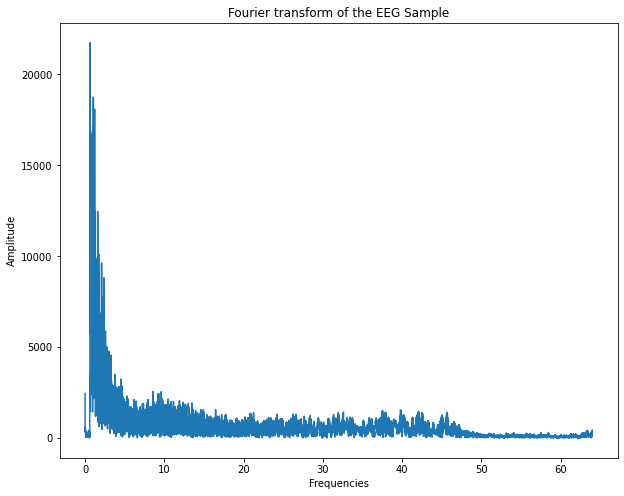

In [259]:
# amplitudes
fft_values = np.absolute(np.fft.rfft(eeg_sample))

# frequencies
fft_freq = np.fft.rfftfreq(len(eeg_sample), 1.0/fs)

# Plot the fourier transform
figure = plt.figure(figsize=(10, 8))
plt.plot(fft_freq, fft_values)
plt.ylabel("Amplitude")
plt.xlabel("Frequencies")
plt.title("Fourier transform of the EEG Sample")
plt.show()

## Amplitude of frequency bands

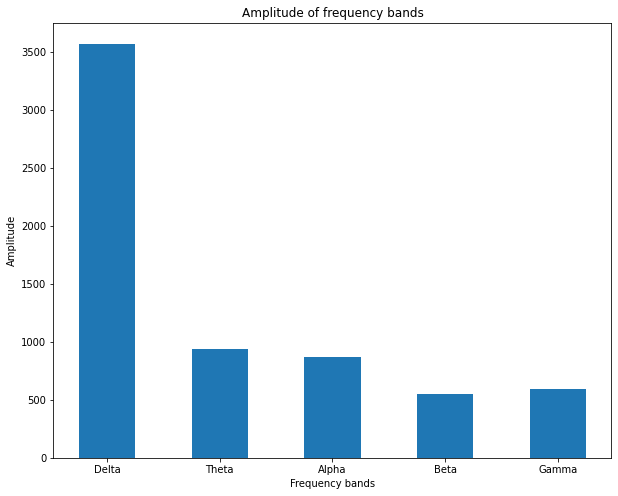

In [260]:
# Categorize the bands
eeg_bands = {'Delta': (0, 4),
             'Theta': (4, 8),
             'Alpha': (8, 12),
             'Beta': (12, 30),
             'Gamma': (30, 45)}

eeg_band_fft = dict()

for band in eeg_bands.keys():
    freq_idx = np.where((fft_freq >= eeg_bands[band][0]) & (fft_freq <= eeg_bands[band][1]))
    
    # sum the amplitudes of the bands
    eeg_band_fft[band] = fft_values[freq_idx]
    
    
# Plot the bands
bands = [band for band in eeg_band_fft.keys()]
mean_amplitude = [np.mean(amp) for amp in eeg_band_fft.values()]

figure = plt.figure(figsize=(10, 8))
plt.bar(bands, mean_amplitude, width=0.5)
plt.xlabel("Frequency bands")
plt.ylabel("Amplitude")
plt.title("Amplitude of frequency bands")
plt.show()

## Calculate parameters: The Delta band

In [264]:
delta = eeg_band_fft['Delta']

# Sample entropy
delta_sampen = ant.sample_entropy(delta)

# 25th Percentile
delta_25 = delta_25 = np.percentile(delta, 25)

# Standard deviation
delta_std = np.std(delta)

# Median crossing 
median_crossing_indices = np.nonzero(np.diff(np.array(delta) > np.median(delta)))[0]
median_crossing_indices = len(median_crossing_indices)

<br/>

## Spectral Analysis: Performing DWT

<br/>

<br/>

# Windowing

The workflow in the walkthrough section is used to create the ```generate_samples``` and ```generate_DFTParameters``` functions. The **Awake** state is used for testing. Windowing is performed because the complexity features are computed using five-second small windows with 50% overlap.

In [268]:
# Generate the windows
def generate_samples(bis, eeg, window_size=5, overlap=0.5, sampling_rate=128):
    """
    Generates EEG samples for consecutive windows 
    and their corresponding BIS value
    
    
    Parameters
    ----------       
    eeg: (n,) array. 
        EEG Sample. Length MUST be a multiple of *samping_rate*.
        
    bis: (n,) array
        BIS Sample
        
    window_size: int, default: 5 
        Duration of each window in seconds
        
    overlap: float, default: 0.5
        Overlap of samples
        
    sampling_rate: float default: 128
        Sampling rate of the EEG sample in Hz.
        
    
    Generates
    ---------
    tup: tuple(bis_mode, eeg_sample)
    
        bis_mode: float
            Modal BIS value of the EEG Sample
        
        eeg_sample: array
            EEG Sample for a 5 second window
        
        
        
    Example
    -------
    >>> awake = np.array([82.8])
    >>> eeg = array([ 0.17727497,  0.17783894,  0.17834346,  0.17878847,  0.17917353,
        0.17949788,  0.17976084,  0.17996202,  0.18010136,  0.18017881, ...])
       
    >>> # Create the generator
    >>> gen_sample = generate_samples(bis, eeg)
    
    >>> # Generate EEG sample
    >>> sample = next(gen_sample)
    
    
    Notes
    -----
    The function works well with the generate_DFTParameters function.
    
    >>> generate_DFTParameters(sample)
           Sampen_Delta  Sampen_Beta  Sampen_Theta  Sampen_Gamma  Sampen_Alpha   BIS
    0      0.075986      0.206614     0.405465      1.290984      0.980829       84.5
    
    """
    from math import floor
    from scipy import stats
    
    bis_len = len(bis)
    eeg_len = len(eeg)
    
    if bis_len < window_size:
        print("Length of BIS values must be greater than {}".format(window_size))
        return
    
    if eeg_len < bis_len * sampling_rate:
        print("Not enough EEG samples")
        return
    

    
    start, end = 0, window_size
    
    eeg_start, eeg_end = 0, end * sampling_rate
    
    
    while True:
        if end > bis_len:
            break
        
        bis_mode = stats.mode(bis[start:end]).mode[0]
        
        eeg_sample = eeg[eeg_start:eeg_end]
        
        tup = (bis_mode, eeg_sample)
        
        yield tup
        
        # update ranges
        start += floor(window_size * overlap)
        end += floor(window_size * overlap)
        
        eeg_start = start * sampling_rate
        eeg_end = end * sampling_rate


    

In [270]:
# A generator that generates EEG signals
gen = generate_samples(awake, eeg_sample, window_size=5)

In [271]:
# Generate a sample EEG signal
sample = next(gen)

In [ ]:
sample

<br/>

# Feature Extraction

## DFT

In [253]:
def generate_DFTParameters(eeg_sample, sampling_rate=128):
    """
    Generate the DFT parameters of EEG segments
    
    
    Parameters
    ----------
    eeg_sample: tuple(bis_mode, eeg)
    
        bis_mode: float
            Bispectral Index
            
        eeg: (n,) array 
            EEG Data
        
        
    bis_value: float
        BIS index for the EEG segment
        
    sampling_rate: int
        Sampling rate of the EEG segment
        
        
    Returns
    -------
    df : pd.DataFrame
        DataFrame of EEG parameters
        
    
    Notes
    -----
    Works well with the generate_samples function. See the documentation on generate_samples.
    """
    
    # amplitudes
    fft_values = np.absolute(np.fft.rfft(eeg_sample[1]))

    # frequencies
    fft_freq = np.fft.rfftfreq(len(eeg_sample[1]), 1.0/sampling_rate)
    
    # Analysing the bands
    eeg_bands = {'Delta': (0, 4),
                 'Theta': (4, 8),
                 'Alpha': (8, 12),
                 'Beta': (12, 30),
                 'Gamma': (30, 45)}

    eeg_band_fft = dict()

    for band in eeg_bands.keys():
        freq_idx = np.where((fft_freq >= eeg_bands[band][0]) & (fft_freq <= eeg_bands[band][1]))

        # sum the amplitudes of the bands
        eeg_band_fft[band] = fft_values[freq_idx]
        
    
    # Sample entropy of the delta band
    sampen_delta = ant.sample_entropy(eeg_band_fft['Delta'])
    sampen_beta = ant.sample_entropy(eeg_band_fft['Beta'])
    sampen_theta = ant.sample_entropy(eeg_band_fft['Theta'])
    sampen_gamma = ant.sample_entropy(eeg_band_fft['Gamma'])
    sampen_alpha = ant.sample_entropy(eeg_band_fft['Alpha'])
    
    
    # produce DataFrame of DFT Parameters
    df = pd.DataFrame([[sampen_delta, sampen_beta, sampen_theta, sampen_gamma, sampen_alpha, eeg_sample[0]]], columns=["Sampen_Delta", "Sampen_Beta", "Sampen_Theta", "Sampen_Gamma", "Sampen_Alpha", "BIS"])
    
    return df
    
    
    

In [254]:
# Get the parameters of the frequency bands
generate_DFTParameters(sample)

,Sampen_Delta,Sampen_Beta,Sampen_Theta,Sampen_Gamma,Sampen_Alpha,BIS
0,0.075986,0.206614,0.405465,1.290984,0.980829,84.5


<br/>

## DWT

In [274]:
def generate_DWTParameters():
    pass